# FACTM on artificial data: an example

## Packages

In [1]:
from tqdm import tqdm
import numpy as np
from copy import deepcopy
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.optimize import linear_sum_assignment

import sys
# load FACTM code
sys.path.append('factm')
from model_class import *
from FACTM_model import *

# load code that produces artificial data
sys.path.append('simulations/data_generation')
from generate_artificial_data_fun import *


## Artificial dataset: parameters and sampling

In [2]:
# draw a sample

# basic params
N = 500 # number of observations
M = 3 # number of views
K = 5 # number of hidden factors
D = [10, 10, 10] # number of features in views
G = 100 # number of distinct words
L = D[2] # number of topics (the last view is not observed directly - we observe words)

# factor-wise sparsity:
var_weights = []
var_weight_M0 = np.ones((D[0], K))
var_weight_M0[:,1] = 0
var_weight_M0[:,4] = 0
var_weight_M1 = np.ones((D[1], K))
var_weight_M1[:,2] = 0
var_weight_M2 = np.ones((D[2], K))
var_weight_M2[:,3:] = 0
var_weights = [var_weight_M0, var_weight_M1, var_weight_M2]

simulations_sample_fa_params = {'K': K, 'N': N, 'D': D, 'M': M, 'sparsity_factor_fraction': 0, 'sparsity_feature_fraction': 0,
                                'var_weights': var_weights}
simulations_sample_ctm_params = {'N': N, 'G': G, 'L': L, 'sentences_per_observation': 'constant', 
                                 'sentences_per_observation_params': {'const': 100},
                                 'words_per_sentence': 20, 'FA': True}
which_ctm = [False, False, True]

In [3]:
data_simulations, data_fa_info, data_ctm_info = simulations_sample_factm(which_ctm, simulations_sample_fa_params, simulations_sample_ctm_params, seed=123)

## Fitting and analysing the model

This section focuses on the process of fitting the model and performing simple analysis to evaluate its performance.

In [4]:
factm = FACTModel(data=data_simulations, K=5, O=[True, True, False], L=[L], S=[True, True, False], seed=123, CTM_t=1)

In [5]:
# Pretraining consists of fitting CTM for each structeed view and PCA for FA part
factm.pretrain()

Pretrain CTM part for a modality 2
Pretrain FA part


In [6]:
# iterations of training
factm.fit(250)

Fitting a model


100%|██████████| 250/250 [12:27<00:00,  2.99s/it]


### ELBO

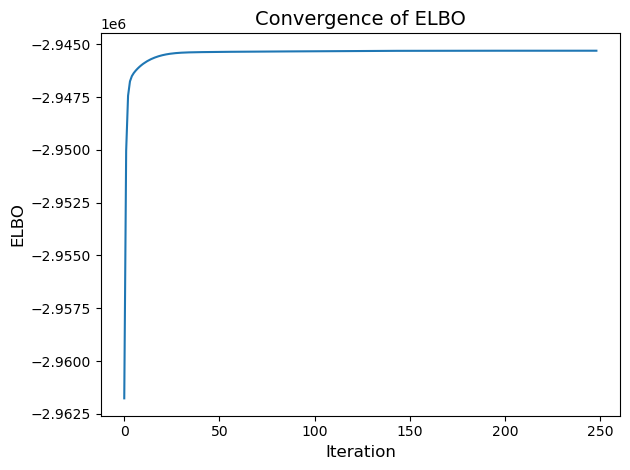

In [7]:
plt.plot(factm.elbo_sequence[1:])
plt.xlabel("Iteration", fontsize=12)
plt.ylabel("ELBO", fontsize=12)
plt.title("Convergence of ELBO", fontsize=14)
plt.tight_layout()
plt.show()

### Explained variance

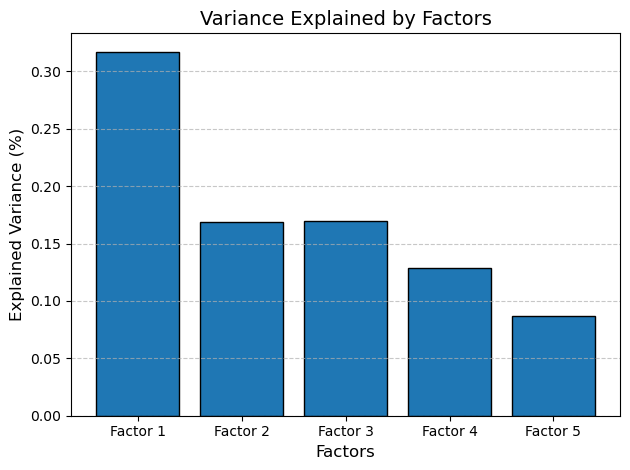

In [8]:
variance_explained = factm.fa.variance_explained_per_factor() 
factors = [f"Factor {i}" for i in range(1, 6)]

plt.bar(factors, variance_explained, edgecolor='black')
plt.xlabel("Factors", fontsize=12)
plt.ylabel("Explained Variance (%)", fontsize=12)
plt.title("Variance Explained by Factors", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### Latent factors

Here, we compare $\hat \mu_Z$ (variational mean of the latent factors $Z$) with the true values (known, as the data is artificial).

Note: $\hat \mu_Z$ may differ from the true values in terms of order and sign. To address this, we match the estimated values with the true ones using the Hungarian algorithm.

In [9]:
corr_z = np.corrcoef(factm.fa.node_z.vi_mu.T, data_fa_info['z'].T)[:K, K:]
order_of_HF = linear_sum_assignment(-np.abs(corr_z))

Correlation matrix between true and estimated hidden factors

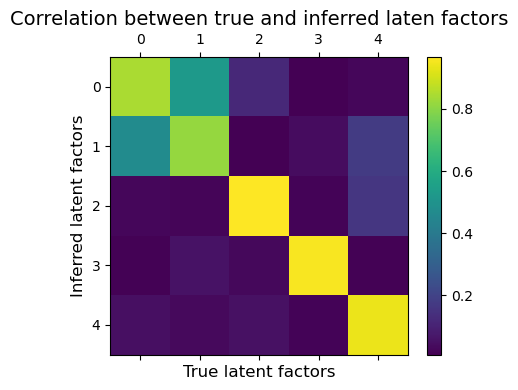

In [10]:
plt.matshow(np.abs(np.corrcoef(factm.fa.node_z.vi_mu.T, data_fa_info['z'][:,order_of_HF[1]].T))[:K, K:])
plt.xlabel("True latent factors", fontsize=12)
plt.ylabel("Inferred latent factors", fontsize=12)
plt.title("Correlation between true and inferred laten factors", fontsize=14)
plt.colorbar(shrink=0.8)
plt.show()

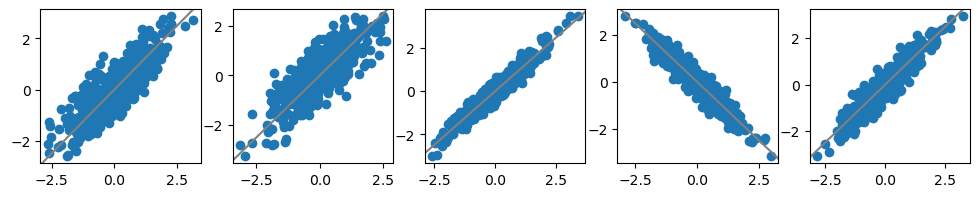

In [11]:
f, axes = plt.subplots(1, K, figsize=(12, 2))
for k in range(K):
    axes[k].scatter(factm.fa.node_z.vi_mu[:,k], data_fa_info['z'][:,order_of_HF[1]][:,k])
    if corr_z[k, order_of_HF[1][k]] > 0:
        axes[k].axline((-2,-2), (2, 2), color='gray')
    else:
        axes[k].axline((-2,2), (2, -2), color='gray')
plt.show()  

### Loading matrix/weights

Here, we compare the estimated loadings with the true ones for View 0.

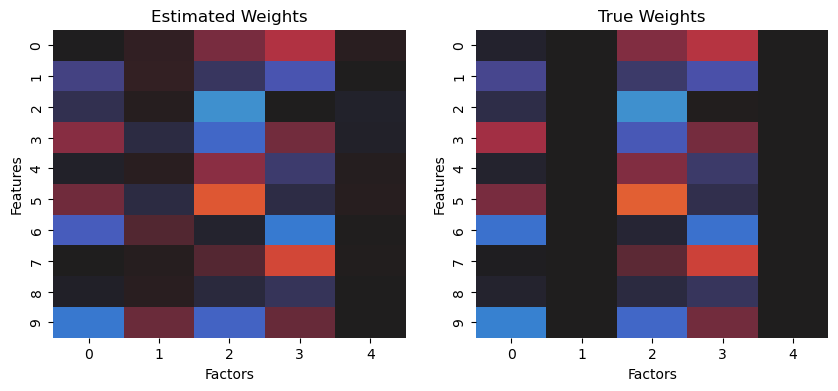

In [12]:
f, axes = plt.subplots(1, 2, figsize=(10, 4))

min0 = -3
max0 = 3

sns.heatmap(factm.fa.nodelist_hat_w[0].vi_mu*(factm.fa.nodelist_s[0].vi_gamma), ax=axes[0], cbar=False, vmin=min0, vmax=max0, center=0)
axes[0].set_title("Estimated Weights", fontsize=12)
axes[0].set_ylabel("Features", fontsize=10)
axes[0].set_xlabel("Factors", fontsize=10)

sns.heatmap(np.sign(np.diag(corr_z[:, order_of_HF[1]]))*data_fa_info['w'][0][:,order_of_HF[1]]*(1-data_fa_info['featurewise_sparsity'][0][:,order_of_HF[1]]), ax=axes[1], cbar=False, vmin=min0, vmax=max0, center=0)
axes[1].set_title("True Weights", fontsize=12)
axes[1].set_ylabel("Features", fontsize=10)
axes[1].set_xlabel("Factors", fontsize=10)

plt.show()

### Topics

#### Contingency table of inferred vs. true topic assignments

The topic ordering is non-identifiable.

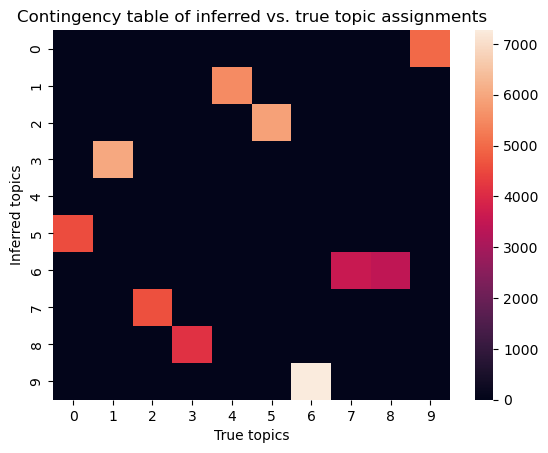

In [13]:
topic_number_est = np.concatenate([np.argmax(factm.ctm_list['M2'].node_xi.vi_par[n], axis=1) for n in range(N)])
topic_number_true = np.concatenate(data_ctm_info['topics_per_sentence'])

cont_tab = pd.crosstab(topic_number_est, topic_number_true)


f, ax = plt.subplots(1, 1)
sns.heatmap(cont_tab, ax=ax)
ax.set_title("Contingency table of inferred vs. true topic assignments", fontsize=12)
ax.set_xlabel("True topics", fontsize=10)
ax.set_ylabel("Inferred topics", fontsize=10)
plt.show()

#### Comparison of topics (as distributions over words)

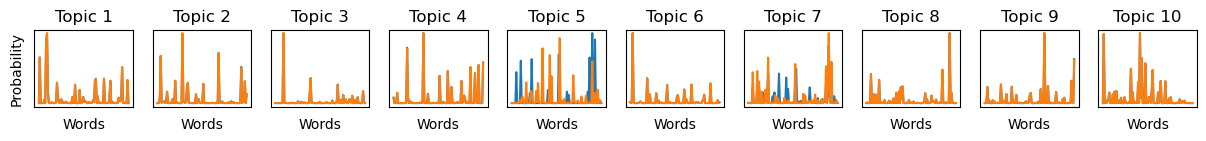

In [14]:
order_of_topics = linear_sum_assignment(-cont_tab)
E_topics = factm.ctm_list['M2'].node_beta.vi_alpha/np.outer(np.sum(factm.ctm_list['M2'].node_beta.vi_alpha, axis=1), np.ones(G))

f, axes = plt.subplots(1, L, figsize=(15, 1))
for l in range(L):
    axes[l].plot(E_topics[l,:])
    axes[l].plot(data_ctm_info['topics'][order_of_topics[1][l],:])
    axes[l].set_yticks([])
    axes[l].set_xticks([])
    axes[l].set_xlabel('Words')
    axes[l].set_title('Topic '+str(l+1))
    if l==0:
        axes[l].set_ylabel('Probability', fontsize=10)
plt.show()  